# Kost Pricing

Pada notebook ini akan dilakukan analisis dalam penentuan harga kost terhadap fasilitas kost. Penentuan harga kost (atau `pricing`) menggunakan algoritma regresi *machine learning* dan juga akan dilakukan interpretasi model untuk analisis fasilitas apa saja yang paling berpengaruh terhadap penentuan harga.

Notebook ini berangkat dari permasalahan ketika seorang pemilik kostan ingin menentukan harga kost perbulannya untuk mendapatkan keuntungan maksimal serta tetap dapat bersaing dengan harga kost lainnya.

Kenapa harus regresi? Kenapa tidak mencari rata-rata/median kost dengan fasilitas yang sama? Permasalahannya adalah bahwa belum tentu selalu ada kombinasi fasilitas kost yang sama dengan kost yang akan ditentukan harganya. Sehingga dilakukan pembangunan model regresi sehingga masukan/kombinasi fasilitas apapun dari kost dapat diprediksi harganya.

Tujuan yang akan dicapai dalam notebook ini antara lain:
1. Melakukan prediksi harga kost berdasarkan fasilitas kost dengan menerapkan algoritma machine learning Regresi Linear, Random Forest Regressor dan juga AdaBoost Regressor.
2. Melakukan analisis terhadap variabel yang paling berpengaruh terhadap hasil prediksi model machine learning yang telah dilatih.

Adapun pembahasan dalam notebook ini antara lain:
1. Persiapan dan Pembersihan Dataset
2. Eksplorasi Data
3. Persiapan Data untuk Model
4. Pembangunan Model
5. Evaluasi Model
6. Perbandingan dengan metode sederhana (atau bisa diatas, sebagai alasan kenapa dilakukan regresi?)
7. Kesimpulan

# Data Pipeline

## Persiapan dan Pembersihan Data

**Membaca Data**

In [69]:
import pandas as pd 
import re as re # Regex

In [70]:
df = pd.read_csv('sewakost_40pages.tsv', sep="\t")

df.head()

,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
0,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Ciganjur Jalan Pasir No. 32,Rp 1.000.000,Kost Campur,Jalan Pasir no 32 Kp. Setu Rt 001/006 Keluraha...,Tidak,Tidak,Ya,['Kamar Mandi Dalam'],"['Keamanan', 'Parkir Motor']"
1,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EXECUTIVE JAGAKARSA PASO CILANDAK JAKARTA...,Rp 2.200.000,Kost Putra,"Jalan Paso no 6A, Jagakarsa, Cilandak, Jakarta...",Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Air Mi..."
2,https://www.sewakost.com/jakarta/selatan/kamar...,Kamar kost Putri NON AC di Mampang,Rp 850.000,Kost Putri,Jl.Mampang Prapatan VI Rt04 Rw02 No.70B,Tidak,Tidak,Tidak,[],[]
3,https://www.sewakost.com/jakarta/selatan/hompy...,Hompy Timur Residence,Rp 2.700.000,Kost Putri,Tebet Timur Dalam 7B no. 11,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Dapur', 'Cuci Setrika', 'Pembantu', 'Keamana..."
4,https://www.sewakost.com/jakarta/selatan/rumah...,Rumah kontrakan (40m2) Pasutri baru/karyawati/...,Rp 2.500.000,Kost Pasutri,Jalan keselamatan 18 RT10/RW03,Ya,Tidak,Ya,"['AC', 'Kamar Mandi Dalam']","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Keaman..."


Kolom:
1. `name`: Nama kost
2. `url`: URL kost
3. `harga`: Harga per bulan
4. `jenis`: Jenis kost: putra, putri or campur
5. `address`: Alamat
6. `aircon`: biner, apakah kost mempunyai AC atau tidak
7. `free_wifi`: biner, apakah kost menyediakan wifi gratis atau tidak
8. `kamar_mandi_dalam`: biner, apakah kamar kost mempunyai kamar mandi dalam atau tidak
9. `fasiltas_kamar`: list fasilitas di dalam kamar
10. `fasilitas_kost`: list fasilitas bersama di gedung kost

## Drop Nilai NaN

Pada bagian ini akan dilihat apakah terdapat nilai NaN pada dataset. Jika terdapat data yang memiliki nilai NaN maka akan dihapus berhubung data tersebut tidak dapat digunakan untuk masukan model.

In [71]:
# Melihat jumlah baris dengan NaN perkolomnya
df.isnull().sum()

url                   0
nama                  0
harga                 0
jenis                14
address              14
aircon               14
free_wifi            14
kamar_mandi_dalam    14
fasilitas_kamar      14
fasilitas_kost       14
dtype: int64

In [72]:
# Menampilkan data dengan row NaN
df[df.isnull().any(axis=1)].head()

,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
483,https://www.sewakost.com/jakarta/selatan/indek...,INDEKOS ELITE DALAM CLUSTER FULL FURNISH,3.000.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
739,https://www.sewakost.com/jakarta/selatan/tebet...,TEBET EXECUTIVE RESIDENCE 141,3.550.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
740,https://www.sewakost.com/jakarta/selatan/sewa-...,"Sewa Kost, Cilandak Barat, Jakarta Selatan",2.000.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
741,https://www.sewakost.com/jakarta/selatan/kos-d...,Kos di Lt.Agung dkt KRL Lt.Agung & Tj.Brt,700.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
742,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Wanita Tebet Dekat Pasar Tebet Barat dan ...,1.600.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Terlihat terdapat 14 data yang memiliki nilai `NaN` pada kolom `jenis`, `address`, `aircon`, `free_wifi`, `kamar_mandi_dalam`, `fasilitas_kamar`, `fasilitas_kost`.

Data-data tersebut akan dihapus dari dataset karena tidak berguna sebagai masukan dari model.

Kenapa tidak dilakukan imputasi terhadap nilai `NaN` misalnya mengisi kolom fasilitas untuk kos dengan harga yang sama? Dalam kasus ini, model regresi yang dibangun akan menggunakan informasi fasilitas kost dalam penentuan harga, kemudian kost dengan harga yang sama/mendekati dapat memiliki fasilitas yang berbeda-beda, sehingga menyulitkan proses imputasi missing value. Maka dari itu missing value dihapus saja. 

In [73]:
# Kode untuk drop semua baris dengan nilai NaN
df.dropna(inplace=True)

# Menampilkan jumlah baris dengan nilai NaN perkolomnya
df.isnull().sum()

url                  0
nama                 0
harga                0
jenis                0
address              0
aircon               0
free_wifi            0
kamar_mandi_dalam    0
fasilitas_kamar      0
fasilitas_kost       0
dtype: int64

Tidak terdapat lagi nilai `NaN` dalam dataset, sehingga dapat melanjutkan ke proses pengolahan data selanjutnya.

## Mengubah Format Data

### Ekstrak Numerik pada Kolom Harga

Kolom `harga` masih dalam format `Rp.[harga]`. Maka dari itu perlu dilakukan ekstraksi nilai numerik terhadap kolom `harga` untuk memudahkan analisis harga.

In [74]:
# Fungsi untuk mengambil setiap nilai numerik kemudian mengubah ke dalam bentuk integer
def find_number(text):
    try:
        # Regex \d untuk mengambil setiap nilai numerik
        num = "".join(re.findall(r'[\d]+',text))
        return int(num)
    except:
        return 0

In [75]:
# Mengubah seluruh kolom harga menjadi integer
df['harga'] = df['harga'].apply(lambda x: find_number(x))

df.head()

,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
0,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Ciganjur Jalan Pasir No. 32,1000000,Kost Campur,Jalan Pasir no 32 Kp. Setu Rt 001/006 Keluraha...,Tidak,Tidak,Ya,['Kamar Mandi Dalam'],"['Keamanan', 'Parkir Motor']"
1,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EXECUTIVE JAGAKARSA PASO CILANDAK JAKARTA...,2200000,Kost Putra,"Jalan Paso no 6A, Jagakarsa, Cilandak, Jakarta...",Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Air Mi..."
2,https://www.sewakost.com/jakarta/selatan/kamar...,Kamar kost Putri NON AC di Mampang,850000,Kost Putri,Jl.Mampang Prapatan VI Rt04 Rw02 No.70B,Tidak,Tidak,Tidak,[],[]
3,https://www.sewakost.com/jakarta/selatan/hompy...,Hompy Timur Residence,2700000,Kost Putri,Tebet Timur Dalam 7B no. 11,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Dapur', 'Cuci Setrika', 'Pembantu', 'Keamana..."
4,https://www.sewakost.com/jakarta/selatan/rumah...,Rumah kontrakan (40m2) Pasutri baru/karyawati/...,2500000,Kost Pasutri,Jalan keselamatan 18 RT10/RW03,Ya,Tidak,Ya,"['AC', 'Kamar Mandi Dalam']","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Keaman..."


kolom `harga` yang tadinya tipe data `string` (contoh: `Rp 1.000.000`) sekarang telah berubah menjadi tipe data `integer`.

### Membersihkan Data dan Perubahan Data

#### Membersihkan Data Dengan Harga Ekstrem

In [76]:
df.describe()

,harga
count,9.440000e+02
mean,3.816841e+09
std,8.280764e+10
min,0.000000e+00
25%,1.000000e+06
50%,1.650000e+06
75%,2.350000e+06
max,1.800000e+12


Terdapat kost-an dengan harga yang sangat murah, termasuk yang 0 rupiah alias gratis (mungkin fasilitasnya selain kamar mandi luar juga harus tidur di luar). Selain kost-an yang sangat murah, tedapat juga kost-an yang sangat mahal hingga seharga 180 juta/bulan.

Kost-an seperti ini tidak akan dianalisis sehingga harus dikeluarkan dari dataset. 

Akan dipertahankan kost-kostan dengan harga di atas 300rb dan di bawah 5 juta. Selain dari pada itu akan dihilangkan dari dataset.

In [77]:
# Drop harga kos di bawah 300rb dan di atas 5 juta
df = df[(df['harga']>=300000) & (df['harga']<=5000000)]

df.shape

(872, 10)

#### Penyesuaian pada Kolom Jenis

Akan dilihat nilai-nilai apa saja yang terdapat pada kolom `jenis` serta jumlah untuk masing-masing jenisnya

In [78]:
df['jenis'].unique()

array(['Kost Campur', 'Kost Putra', 'Kost Putri', 'Kost Pasutri',
       'Kost Keluarga'], dtype=object)

In [79]:
# Melihat jumlah kost berdasarkan jenis
df.groupby('jenis').count()

,url,nama,harga,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
jenis,,,,,,,,,
Kost Campur,484,484,484,484,484,484,484,484,484
Kost Keluarga,7,7,7,7,7,7,7,7,7
Kost Pasutri,15,15,15,15,15,15,15,15,15
Kost Putra,109,109,109,109,109,109,109,109,109
Kost Putri,257,257,257,257,257,257,257,257,257


Berhubung jumlah `kost keluarga` dan `kost pasutri` sangat sedikit, dan juga mereka memiliki makna yang sama, maka dari itu `kost keluarga` diubah nilainya menjadi `kost pasutri` sehingga jumlahnya bertambah.

In [80]:
# Mengubah jenis kost pasutri -> kost keluarga
df['jenis'] = df['jenis'].replace('Kost Keluarga', 'Kost Pasutri')

# Melihat jumlah kost berdasarkan jenis setelah kost keluarga diubah menjadi kost pasutri
df.groupby('jenis').count()

,url,nama,harga,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
jenis,,,,,,,,,
Kost Campur,484,484,484,484,484,484,484,484,484
Kost Pasutri,22,22,22,22,22,22,22,22,22
Kost Putra,109,109,109,109,109,109,109,109,109
Kost Putri,257,257,257,257,257,257,257,257,257


## Ekstrak `fasilitas_kamar` dan `fasilitas_kost` ke Dalam Kolom Dataframe

In [81]:
df[['nama', 'fasilitas_kamar', 'fasilitas_kost']].head()

,nama,fasilitas_kamar,fasilitas_kost
0,Kost Ciganjur Jalan Pasir No. 32,['Kamar Mandi Dalam'],"['Keamanan', 'Parkir Motor']"
1,KOST EXECUTIVE JAGAKARSA PASO CILANDAK JAKARTA...,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Air Mi..."
2,Kamar kost Putri NON AC di Mampang,[],[]
3,Hompy Timur Residence,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Dapur', 'Cuci Setrika', 'Pembantu', 'Keamana..."
4,Rumah kontrakan (40m2) Pasutri baru/karyawati/...,"['AC', 'Kamar Mandi Dalam']","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Keaman..."


Kolom `fasilitas_kamar` dan `fasilitas_kost` nilainya masih berisi list untuk fasilitas per kamar dan fasilitas kost. 
Dalam hal ini untuk kost dengan index `1`, memiliki fasilitas kamar seperti spring bed, perabot, dsb. Untuk fasilitas. kostnya memiliki ruang tamu, ruang makan, dapur dsb. 

Informasi-informasi ini akan dijadikan kolom tersendiri yang akan digunakan sebagai masukan model.

Tahapan-tahapan yang akan dilakukan antara lain:
1. Mendapatkan nilai unik dari `fasilitas_kamar` dan `fasilitas_kost`.
2. Nilai unik dari fasilitas dibuat menjadi kolom baru, Iterasi setiap baris pada dataframe untuk mengecek setiap fasilitas yang dimiliki oleh kost. Jika fasilitas pada kolom baru terdapat pada `fasilitas_kamar` atau `fasilitas_kost` maka kolom baru akan diisi oleh nilai `Ya` dan `Tidak` jika tidak terdapat fasilitas tersebut.

#### 1. Fungsi untuk mengekstrak nilai unik fasilitas

Berikut adalah fungsi untuk mengambil semua nilai unik dari `fasilitas_kamar` atau `fasilitas_kost`.

Tahapan fungsi untuk contoh Input(tipe str): `"['Keamanan', 'Parkir Motor']"`:
1. Berhubung `[]` terdapat pada index `0` dan `-1`, maka dari itu hanya mengambil stringg dengan index mulai dari `1` hingga sebelum `-1`.

Output(str): `"'Keamanan', 'Parkir Motor'"`

2. Mengecek apakah string kosong atau bukan, jika string kosong maka lanjut.
3. Karena masih terdapat simbol kutip 1 (`'`), maka dari itu kutip 1 dihilangkan dengan fungsi `.replace("'", "")`.

Output(str): `"Keamanan, Parkir Motor"`

4. Karena setiap nilai terpisah oleh koma yang diikuti spasi, maka untuk mendapatkan masing-masing nilai digunakan fungsi `.split(", ")`

Output(list): `['Keamanan', 'Parkir Motor']`

5. List tersebut dimasukkan ke dalam list `fasilitas`.

6. Mengulang iterasi, jika list belum terdapat di dalam `fasilitas`, maka nilai dimasukkan ke dalam list `fasilitas`, jika sudah ada, maka iterasi dilanjutkan.

In [82]:
def get_fasilitas(data_fasilitas):
    fasilitas = []
    for n in data_fasilitas:
        data = n[1:-1]
        if data == "":
            continue
        list_fas = data.replace("'", "").split(", ")
        for fas in list_fas:
            if fas not in fasilitas:
                fasilitas.append(fas)
    
    return fasilitas

In [83]:
fasilitas_kamar = get_fasilitas(df['fasilitas_kamar'].unique())
print(f"Nilai Unik fasilitas kamar:\n{fasilitas_kamar}")

fasilitas_kost = get_fasilitas(df['fasilitas_kost'].unique())
print(f"\nNilai unik fasilitas kost:\n{fasilitas_kost}")

Nilai Unik fasilitas kamar:
['Kamar Mandi Dalam', 'Spring Bed', 'Perabot', 'Free WiFi', 'AC', 'TV', 'Pemanas Air (Water Heater)', 'Kulkas']

Nilai unik fasilitas kost:
['Keamanan', 'Parkir Motor', 'Ruang Tamu', 'Ruang Makan', 'Dapur', 'Air Minum', 'Pembantu', 'Parkir Mobil', 'Cuci Setrika', 'Mesin Cuci (Cuci Sendiri)', 'Televisi']


Output dari kode ini adalah setiap fasilitas unik dari kolom `fasilitas_kamar` (8 nilai unik) dan `fasilitas_kost` (11 nilai unik)yang nantinya akan dijadikan sebagai kolom baru.

Berhubung pada `fasilitas_kamar` terdapat nilai `Kamar Mandi Dalam`, `AC`, dan `Free WiFi` dimana nilai tersebut sudah terdapat pada kolom yang lain. Maka dari itu nilai ketiga fasilitas tersebut akan dihapus dari list `fasilitas_kamar` agar tidak terjadi duplikat ketika assign kolom baru.

In [84]:
# Karena sudah ada kolom untuk ini
remove_fasilitas = ['Kamar Mandi Dalam', 'AC', 'Free WiFi']

for fas in remove_fasilitas:
    fasilitas_kamar.remove(fas)

print(fasilitas_kamar)

['Spring Bed', 'Perabot', 'TV', 'Pemanas Air (Water Heater)', 'Kulkas']


Untuk `fasilitas_kamar`, akan dibentuk 5 kolom baru sesuai fasilitas pada output cell di atas ini.

#### 2. Assign Kolom Baru Untuk Fasilitas

Tahapan yang dilakukan:
1. Iterasi masing-masing nilai unik pada fasilitas (`fasilitas_kamar` dan `fasilitas_kost`)
2. Iterasi masing-masing baris pada dataframe, jika baris tersebut memiliki fasilitas pada kolom baru, maka assign nilai `Ya`, jika tidak, maka `Tidak`.
3. Drop kolom `fasilitas_kamar` dan `fasilitas_kost` karena informasinya telah digantikan oleh kolom-kolom fasilitas baru.

In [85]:
# Fungsi untuk iterasi setiap baris untuk fasilitas tertentu
def get_info(fas_kamar, fas):
    data = []
    for row in fas_kamar:
        status = "Ya" if fas in row else "Tidak"
        data.append(status)
    return data

In [86]:
# Iterasi setiap fasilitas baru untuk dijadikan kolom
for fas in fasilitas_kamar:
    kolom_baru = fas + "_fkamar"
    df[kolom_baru] = get_info(df['fasilitas_kamar'], fas)

for fas in fasilitas_kost:
    kolom_baru = fas + "_fkost"
    df[kolom_baru] = get_info(df['fasilitas_kost'], fas)

In [87]:
# Drop
df = df.drop(['fasilitas_kamar', 'fasilitas_kost'], axis=1)

In [88]:
df.head()

,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,Spring Bed_fkamar,Perabot_fkamar,...,Parkir Motor_fkost,Ruang Tamu_fkost,Ruang Makan_fkost,Dapur_fkost,Air Minum_fkost,Pembantu_fkost,Parkir Mobil_fkost,Cuci Setrika_fkost,Mesin Cuci (Cuci Sendiri)_fkost,Televisi_fkost
0,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Ciganjur Jalan Pasir No. 32,1000000,Kost Campur,Jalan Pasir no 32 Kp. Setu Rt 001/006 Keluraha...,Tidak,Tidak,Ya,Tidak,Tidak,...,Ya,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak
1,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EXECUTIVE JAGAKARSA PASO CILANDAK JAKARTA...,2200000,Kost Putra,"Jalan Paso no 6A, Jagakarsa, Cilandak, Jakarta...",Ya,Ya,Ya,Ya,Ya,...,Ya,Ya,Ya,Ya,Ya,Ya,Ya,Tidak,Tidak,Tidak
2,https://www.sewakost.com/jakarta/selatan/kamar...,Kamar kost Putri NON AC di Mampang,850000,Kost Putri,Jl.Mampang Prapatan VI Rt04 Rw02 No.70B,Tidak,Tidak,Tidak,Tidak,Tidak,...,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak
3,https://www.sewakost.com/jakarta/selatan/hompy...,Hompy Timur Residence,2700000,Kost Putri,Tebet Timur Dalam 7B no. 11,Ya,Ya,Ya,Ya,Ya,...,Ya,Tidak,Tidak,Ya,Tidak,Ya,Tidak,Ya,Tidak,Tidak
4,https://www.sewakost.com/jakarta/selatan/rumah...,Rumah kontrakan (40m2) Pasutri baru/karyawati/...,2500000,Kost Pasutri,Jalan keselamatan 18 RT10/RW03,Ya,Tidak,Ya,Tidak,Tidak,...,Ya,Ya,Ya,Ya,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak


In [89]:
df.shape

(872, 24)

Terlihat pada `df` terdapat tambahan 14 kolom baru. Dimana kolom-kolom tersebut adalah informasi untuk masing-masing fasilitas. Contoh pada kolom `Spring Bed_fkamar` memiliki dua nilai yaitu `Ya` atau `Tidak` yang menandakan apakah disediakan Spring Bed untuk masing-masing kost atau tidak. Begitupun dengan kolom-kolom lainnya dengan nilai `Ya` atau `Tidak`.

Selanjutnya dataframe dalam bentuk ini dieksport ke dalam .tsv baru untuk memudahkan pengolahan data selanjutnya.

In [90]:
# Menyimpan data
df.to_csv('sewakost_clean.tsv', sep="\t", index = False)

# Eksplorasi Data

Pada tahapan ini akan dilakukan eksplorasi data, mencari korelasi antar variabel serta persiapan data untuk pembangunan model.

In [62]:
import pandas as pd
import numpy as np

In [63]:
kost_clean = pd.read_csv('sewakost_clean.tsv', sep="\t")

kost_clean.head(5)

,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,Spring Bed_fkamar,Perabot_fkamar,...,Parkir Motor_fkost,Ruang Tamu_fkost,Ruang Makan_fkost,Dapur_fkost,Air Minum_fkost,Pembantu_fkost,Parkir Mobil_fkost,Cuci Setrika_fkost,Mesin Cuci (Cuci Sendiri)_fkost,Televisi_fkost
0,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Ciganjur Jalan Pasir No. 32,1000000,Kost Campur,Jalan Pasir no 32 Kp. Setu Rt 001/006 Keluraha...,Tidak,Tidak,Ya,Tidak,Tidak,...,Ya,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak
1,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EXECUTIVE JAGAKARSA PASO CILANDAK JAKARTA...,2200000,Kost Putra,"Jalan Paso no 6A, Jagakarsa, Cilandak, Jakarta...",Ya,Ya,Ya,Ya,Ya,...,Ya,Ya,Ya,Ya,Ya,Ya,Ya,Tidak,Tidak,Tidak
2,https://www.sewakost.com/jakarta/selatan/kamar...,Kamar kost Putri NON AC di Mampang,850000,Kost Putri,Jl.Mampang Prapatan VI Rt04 Rw02 No.70B,Tidak,Tidak,Tidak,Tidak,Tidak,...,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak
3,https://www.sewakost.com/jakarta/selatan/hompy...,Hompy Timur Residence,2700000,Kost Putri,Tebet Timur Dalam 7B no. 11,Ya,Ya,Ya,Ya,Ya,...,Ya,Tidak,Tidak,Ya,Tidak,Ya,Tidak,Ya,Tidak,Tidak
4,https://www.sewakost.com/jakarta/selatan/rumah...,Rumah kontrakan (40m2) Pasutri baru/karyawati/...,2500000,Kost Pasutri,Jalan keselamatan 18 RT10/RW03,Ya,Tidak,Ya,Tidak,Tidak,...,Ya,Ya,Ya,Ya,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak


Harga akan dibagi seribu untuk memudahkan pembacaan angka. Sehingga yang tadinya 1000000 (1 juta) akan menjadi 1000, begitupun untuk 900000 (sembilan ratus ribu) hanya akan menjadi 900

In [64]:
kost_clean['harga'] = kost_clean['harga'] / 1e3

kost_clean.head()

,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,Spring Bed_fkamar,Perabot_fkamar,...,Parkir Motor_fkost,Ruang Tamu_fkost,Ruang Makan_fkost,Dapur_fkost,Air Minum_fkost,Pembantu_fkost,Parkir Mobil_fkost,Cuci Setrika_fkost,Mesin Cuci (Cuci Sendiri)_fkost,Televisi_fkost
0,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Ciganjur Jalan Pasir No. 32,1000.0,Kost Campur,Jalan Pasir no 32 Kp. Setu Rt 001/006 Keluraha...,Tidak,Tidak,Ya,Tidak,Tidak,...,Ya,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak
1,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EXECUTIVE JAGAKARSA PASO CILANDAK JAKARTA...,2200.0,Kost Putra,"Jalan Paso no 6A, Jagakarsa, Cilandak, Jakarta...",Ya,Ya,Ya,Ya,Ya,...,Ya,Ya,Ya,Ya,Ya,Ya,Ya,Tidak,Tidak,Tidak
2,https://www.sewakost.com/jakarta/selatan/kamar...,Kamar kost Putri NON AC di Mampang,850.0,Kost Putri,Jl.Mampang Prapatan VI Rt04 Rw02 No.70B,Tidak,Tidak,Tidak,Tidak,Tidak,...,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak
3,https://www.sewakost.com/jakarta/selatan/hompy...,Hompy Timur Residence,2700.0,Kost Putri,Tebet Timur Dalam 7B no. 11,Ya,Ya,Ya,Ya,Ya,...,Ya,Tidak,Tidak,Ya,Tidak,Ya,Tidak,Ya,Tidak,Tidak
4,https://www.sewakost.com/jakarta/selatan/rumah...,Rumah kontrakan (40m2) Pasutri baru/karyawati/...,2500.0,Kost Pasutri,Jalan keselamatan 18 RT10/RW03,Ya,Tidak,Ya,Tidak,Tidak,...,Ya,Ya,Ya,Ya,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak


## Binary Encoding

Terlihat pada dataframe ini, kolom fasilitas dimulai dari kolom dengan index 5 (index dimulai dari 0) hingga kolom dengan index terakhir.

In [65]:
kost_clean.iloc[:, 5:].head()

,aircon,free_wifi,kamar_mandi_dalam,Spring Bed_fkamar,Perabot_fkamar,TV_fkamar,Pemanas Air (Water Heater)_fkamar,Kulkas_fkamar,Keamanan_fkost,Parkir Motor_fkost,Ruang Tamu_fkost,Ruang Makan_fkost,Dapur_fkost,Air Minum_fkost,Pembantu_fkost,Parkir Mobil_fkost,Cuci Setrika_fkost,Mesin Cuci (Cuci Sendiri)_fkost,Televisi_fkost
0,Tidak,Tidak,Ya,Tidak,Tidak,Tidak,Tidak,Tidak,Ya,Ya,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak
1,Ya,Ya,Ya,Ya,Ya,Ya,Tidak,Tidak,Tidak,Ya,Ya,Ya,Ya,Ya,Ya,Ya,Tidak,Tidak,Tidak
2,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak
3,Ya,Ya,Ya,Ya,Ya,Tidak,Ya,Tidak,Ya,Ya,Tidak,Tidak,Ya,Tidak,Ya,Tidak,Ya,Tidak,Tidak
4,Ya,Tidak,Ya,Tidak,Tidak,Tidak,Tidak,Tidak,Ya,Ya,Ya,Ya,Ya,Tidak,Tidak,Tidak,Tidak,Tidak,Tidak


Pada setiap kolom fasilitas nilai masih dalam bentuk `Ya` atau `Tidak`. Nilai kategorikal ini akan kita ubah menjadi nilai `1` untuk `Ya` dan `0` untuk `Tidak`. Proses ini biasanya dikenal sebagai *Binary Encoding*. Melakukan *encoding* bermanfaat dalam pemrosesan/pembelajaran data salah satunya dapat mempercepat proses pengolahan/pembelajaran data.<sup>[[1](https://www.sciencedirect.com/topics/engineering/binary-encoding)]</sup>

Tahapan selanjutnya akan dilakukan *binary encoding* untuk mengubah kolom fasilitas menjadi nilai `0` dan `1`.

In [66]:
# Mencari nilai `Ya`, jika iya maka nilai diubah menjadi 1, jika tidak menjadi 0
kost_clean.iloc[:, 5:] = np.where(kost_clean.iloc[:, 5:] == 'Ya', 1, 0)

In [67]:
kost_clean.iloc[:, 5:].head()

,aircon,free_wifi,kamar_mandi_dalam,Spring Bed_fkamar,Perabot_fkamar,TV_fkamar,Pemanas Air (Water Heater)_fkamar,Kulkas_fkamar,Keamanan_fkost,Parkir Motor_fkost,Ruang Tamu_fkost,Ruang Makan_fkost,Dapur_fkost,Air Minum_fkost,Pembantu_fkost,Parkir Mobil_fkost,Cuci Setrika_fkost,Mesin Cuci (Cuci Sendiri)_fkost,Televisi_fkost
0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,0,1,0,1,1,0,0,1,0,1,0,1,0,0
4,1,0,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0


In [68]:
kost_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   url                                872 non-null    object 
 1   nama                               872 non-null    object 
 2   harga                              872 non-null    float64
 3   jenis                              872 non-null    object 
 4   address                            872 non-null    object 
 5   aircon                             872 non-null    int64  
 6   free_wifi                          872 non-null    int64  
 7   kamar_mandi_dalam                  872 non-null    int64  
 8   Spring Bed_fkamar                  872 non-null    int64  
 9   Perabot_fkamar                     872 non-null    int64  
 10  TV_fkamar                          872 non-null    int64  
 11  Pemanas Air (Water Heater)_fkamar  872 non-null    int64  

Terlihat bahwa dataframe untuk kolom fasilitas semua nilainya telah berubah menjadi nilai `0` atau `1`. Kemudian tipe data dari setiap kolom tersebut juga telah berubah menjadi tipe data `integer`. Sehingga kita dapat melakukan `describe()` untuk melihat karakteristik statistika dari setiap fasilitas.

In [69]:
kost_clean.describe()

,harga,aircon,free_wifi,kamar_mandi_dalam,Spring Bed_fkamar,Perabot_fkamar,TV_fkamar,Pemanas Air (Water Heater)_fkamar,Kulkas_fkamar,Keamanan_fkost,Parkir Motor_fkost,Ruang Tamu_fkost,Ruang Makan_fkost,Dapur_fkost,Air Minum_fkost,Pembantu_fkost,Parkir Mobil_fkost,Cuci Setrika_fkost,Mesin Cuci (Cuci Sendiri)_fkost,Televisi_fkost
count,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000
mean,1825.345183,0.743119,0.737385,0.790138,0.597477,0.447248,0.228211,0.215596,0.144495,0.388761,0.643349,0.395642,0.260321,0.508028,0.290138,0.178899,0.315367,0.147936,0.111239,0.176606
std,953.512104,0.437164,0.440307,0.407444,0.490688,0.497495,0.419920,0.411471,0.351793,0.487749,0.479286,0.489269,0.439062,0.500222,0.454086,0.383488,0.464929,0.355240,0.314608,0.381553
min,400.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1000.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1650.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2300.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,5000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Insight:** 

Pada tabel ini kita dapat berfokus pada `mean` dari setiap fasilitasnya. Dari `mean` kita dapat mengetahui sebaran fasilitas pada semua data kost yang kita miliki. Dalam hal ini jika `mean > 0.5` berarti mayoritas data kost memiliki fasilitas tersebut. Contoh: untuk fasilitas `aircon` memiliki `mean = 0.74`, dapat dikatakan `74 %` data kost memiliki fasilitas `aircon`. Begitu pula dengan `Kulkas_fkamar` hanya memiliki `mean = 0.144` atau dengan kata lain hanya `14%` dari data kost kita yang memiliki fasilitas kulkas dalam kamar.

## Remove Outlier

Selanjutnya akan dilihat persebaran data `harga` menggunakan `boxplot` untuk melihat apakah terdapat outlier.

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='harga'>

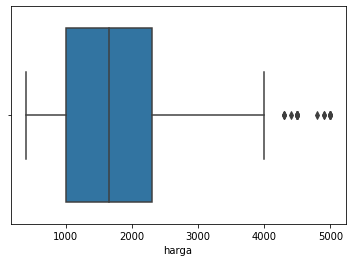

In [71]:
sns.boxplot(x=kost_clean['harga'])

In [72]:
Q1 = kost_clean.harga.quantile(0.25)
Q3 = kost_clean.harga.quantile(0.75)
IQR = Q3-Q1

outlier_bawah = kost_clean[kost_clean['harga'] < (Q1 - 1.5 * IQR)]
outlier_atas = kost_clean[kost_clean['harga'] > (Q3 + 1.5 * IQR)]

print("Jumlah kos lengkap dengan harga di bawah %i adalah = %i" % ((Q1 - 1.5 * IQR), outlier_bawah.shape[0]))
print("Jumlah kos lengkap dengan harga di atas %i adalah = %i" % ((Q3 + 1.5 * IQR), outlier_atas.shape[0]))

Jumlah kos lengkap dengan harga di bawah -950 adalah = 0
Jumlah kos lengkap dengan harga di atas 4250 adalah = 26


Baik dari `boxplot` terlihat terdapat **outlier atas**. Adapun outlier atas tersebut berada di atas harga 4250 rb (4,25 juta). Terdapat 26 kost yang berada dalam outlier atas. Outlier ini akan didrop agar tidak mempengaruhi model.

<AxesSubplot:xlabel='harga'>

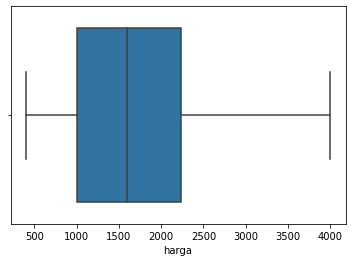

In [73]:
# Drop data outlier, hanya mengambil kost
kost_clean = kost_clean[kost_clean['harga']<=(Q3 + 1.5 * IQR)]

sns.boxplot(x=kost_clean['harga'])

Hasil boxplot setelah data outlier dikeluarkan. Telah tidak terlihat outlier lagi.

## Korelasi

Hal selanjutnya adalah kita akan melihat korelasi antar variabelnya, khususnya yang diperhatikan adalah korelasi antara kolom **harga** dan **fasilitas**. 

Hal ini dilakukan untuk mengetahui fasilitas apa saja yang mempengaruhi harga berdasarkan fasilitasnya. Ini berguna bagi data saintis yang membangun model untuk menggunakan variabel apa saja sebagai masukan model dan juga pemilik kost dalam menentukan fasilitas apa saja yang seharusnya disediakan untuk menaikkan harga kost.

In [74]:
correlation_matrix = kost_clean.corr().round(2)

Text(0.5, 1.0, 'Matriks Korelasi Terhadap Fitur Numerik')

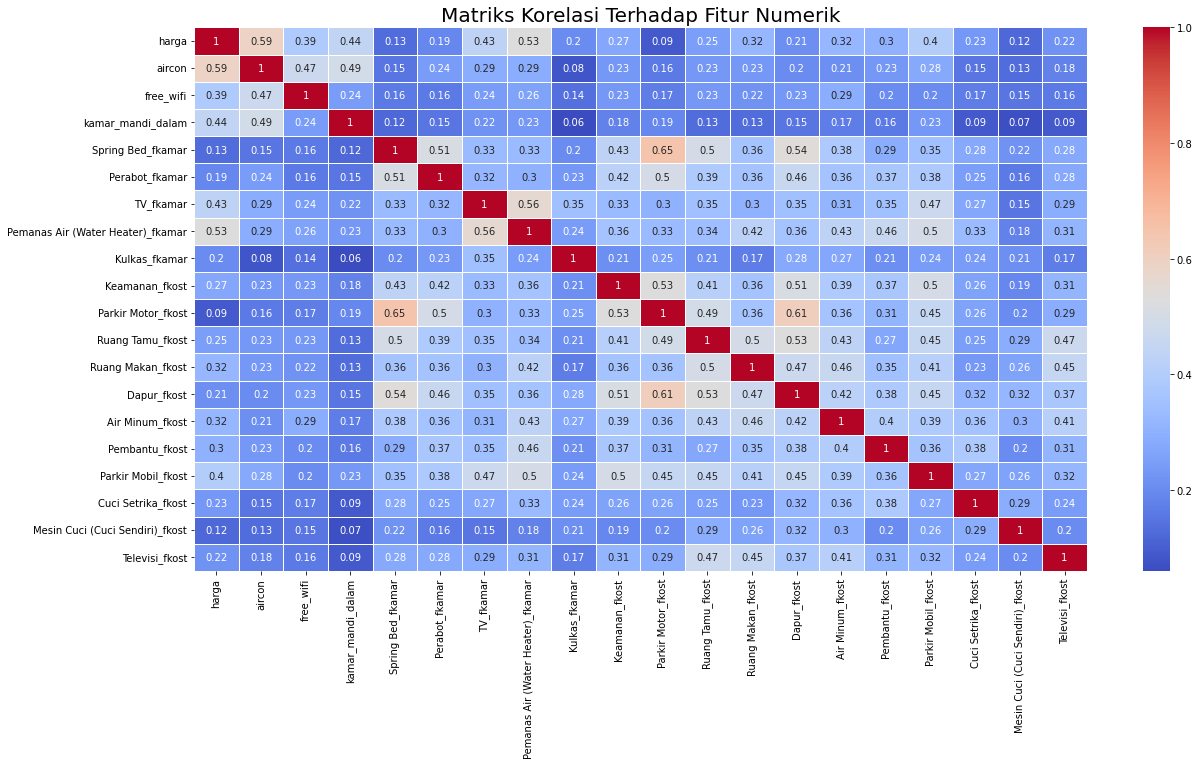

In [75]:
plt.figure(figsize=(20, 10))
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matriks Korelasi Terhadap Fitur Numerik", size=20)

Kolom pertama adalah pengaruh fasilitas terhadap harga kost. Selain itu dapat terlihat juga korelasi antar fasilitas.

Selanjutnya kita akan berfokus kepada korelasi harga terhadap fasilitas.

Text(0.5, 1.0, 'Korelasi Fasilitas Terhadap Harga Kost')

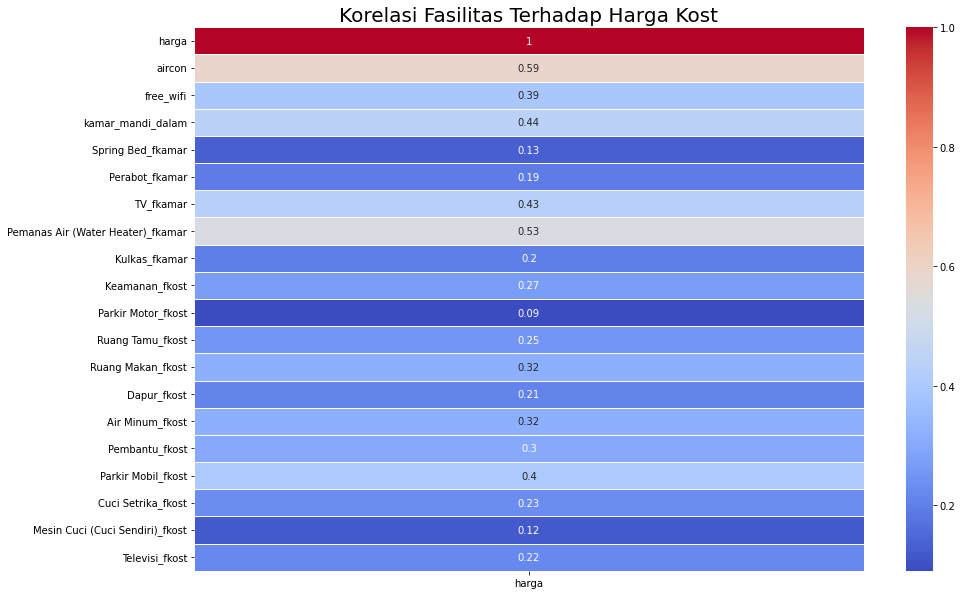

In [76]:
korelasi_harga = correlation_matrix[['harga']]
plt.figure(figsize=(15, 10))
sns.heatmap(data=korelasi_harga, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Korelasi Fasilitas Terhadap Harga Kost", size=20)

Grafik di atas memperlihatkan korelasi antara harga terhadap fasilitas. Fasilitas dengan korelasi tinggi menandakan fasilitas tersebut berpengaruh tinggi terhadap kenaikan harga kost. 3 fasilitas yang paling mempengaruhi harga kost adalah ac (0.59), pemanas air (0.53) dan kamar mandi dalam (0.44)

Selanjutnya akan dipilih kost-kost dengan korelasi tinggi terhadap harga kost, dalam hal ini ditentukan fasiltias dengan korelasi di atas 0.25 adalah fasilitas yang akan dipertahakan sebagai masukan dari model untuk dipelajari. (Angka 0.25 adalah pilihan subjektif dari penulis kode, jika ingin dapat menentukan angka/threshold lain yang dianggap berpengaruh)

In [77]:
# Mempertahankan feature dengan korelasi di atas 0.25
korelasi_tinggi = korelasi_harga[korelasi_harga['harga'] >= 0.25]

korelasi_tinggi

,harga
harga,1.00
aircon,0.59
free_wifi,0.39
kamar_mandi_dalam,0.44
TV_fkamar,0.43
Pemanas Air (Water Heater)_fkamar,0.53
Keamanan_fkost,0.27
Ruang Tamu_fkost,0.25
Ruang Makan_fkost,0.32
Air Minum_fkost,0.32


## One Hot Encoding

Kemudian kita mencoba untuk melihat rata-rata serta median dari harga kost untuk masing-masing dari jenis kost.

In [78]:
kost_clean.groupby(kost_clean['jenis'])[['harga']].mean()

,harga
jenis,
Kost Campur,1984.307190
Kost Pasutri,2814.285714
Kost Putra,1212.889908
Kost Putri,1432.680934


In [79]:
kost_clean.groupby(kost_clean['jenis'])[['harga']].median()

,harga
jenis,
Kost Campur,1900.0
Kost Pasutri,3000.0
Kost Putra,1100.0
Kost Putri,1300.0


Dari rata-rata dan median, diketahui kost putra memiliki harga cenderung lebih murah, diikuti oleh kost putri dan campur dan yang termahal adalah kost pasutri.

Informasi `jenis` kost dapat dijadikan sebagai masukan untuk pembelajaran model. Karena kolom `jenis` memiliki 4 kategori, sehingga dapat dilakukan One Hot Encoding untuk mengubah data kategorikal menjadi kolom boolean sehingga dapat meningkatkan performa ML dalam melakukan prediksi.<sup>[[2](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)]</sup>

In [80]:
from sklearn.preprocessing import OneHotEncoder

# Mendapatkan nama kolom hasil one hot
kolom_oneHot = pd.get_dummies(kost_clean['jenis'], prefix='jenis').columns.to_list()
# Melakukan one hot encoding untuk kolom jenis
kost_clean = pd.concat([kost_clean, pd.get_dummies(kost_clean['jenis'], prefix='jenis')], axis=1)
# Drop kolom jenis (kolom asal untuk one hot)
kost_clean.drop(['jenis'], axis=1, inplace=True)

In [81]:
# Subset kolom yang memiliki korelasi tinggi + kolom hasil dummy jenis kost
kost_clean_korelasi = kost_clean[korelasi_tinggi.index.to_list() + kolom_oneHot]

kost_clean_korelasi.head()

,harga,aircon,free_wifi,kamar_mandi_dalam,TV_fkamar,Pemanas Air (Water Heater)_fkamar,Keamanan_fkost,Ruang Tamu_fkost,Ruang Makan_fkost,Air Minum_fkost,Pembantu_fkost,Parkir Mobil_fkost,jenis_Kost Campur,jenis_Kost Pasutri,jenis_Kost Putra,jenis_Kost Putri
0,1000.0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0
1,2200.0,1,1,1,1,0,0,1,1,1,1,1,0,0,1,0
2,850.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2700.0,1,1,1,0,1,1,0,0,0,1,0,0,0,0,1
4,2500.0,1,0,1,0,0,1,1,1,0,0,0,0,1,0,0


Setiap kategori dari kolom `jenis` telah menjadi kolom baru dengan nilai boolean, dimana jika kolom `jenis_Kost Campur` memiliki nilai `1` menandakan bahwa kost tersebut adalah kost campur, sebaliknya untuk nilai `0`.

# Train Test Split

Tahap selanjutnya adalah membagi variabel independen/prediktor dan juga variabel dependen/target dan juga melakukan pembagian data ke dalam data train dan data test dengan komposisi 80% data train 20% data test. Data test nantinya akan digunakan sebagai data evaluasi model, untuk melihat sebaik apa model dalam memprediksi harga kost untuk data yang belum pernah dipelajari sebelumnya.

In [82]:
# Pembagian data latih dan data uji
from sklearn.model_selection import train_test_split

# # Untuk korelasi tinggi
X = kost_clean_korelasi.drop(['harga'], axis=1)
y = kost_clean_korelasi['harga']

# Membagi ke dalam 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [83]:
print(f"""
Total Dataset: {len(X)}
Train Dataset: {len(X_train)}
Test Dataset: {len(X_test)}
""")


Total Dataset: 846
Train Dataset: 676
Test Dataset: 170



Dari total 846 dataset. 676 data digunakan sebagai data training, dan 170nya akan digunakan sebagai data test.

# Pembangunan Model

Model regresi yang akan digunakan antara lain Linear Regression, Random Forest Regressor dan Ada Boost Regressor.

In [84]:
# Dataframe nantinya untuk evaluasi ketiga model
models = pd.DataFrame(
    index=['train_mae', 'test_mae'],
    columns=['LinearRegression', 'RandomForest', 'Boosting'])

## Linear Regression

LinearRegression akan melakukan pelatihan model dengan koefisien w = (w1, ..., wp) untuk meminimalkan residual *sum of squares* antara target pada dataset dengan nilai target hasil prediksi berdasarkan pendekatan persamaan linear.<sup>[[3](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)]</sup>

In [85]:
from sklearn.linear_model import LinearRegression

# Fitting data training ke algoritma linearregression
model_lr = LinearRegression().fit(X_train, y_train)

model_lr

LinearRegression()

## Random Forest Regressor

Ide dasar dari Random Forest adalah untuk menyatukan beberapa *decision tree* dalam menentukan final output alih-alih hanya bergantung pada satu *decision tree*.<sup>[[4](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)]</sup> 

`RandomForesttRegressor` memiliki beberapa parameter, diantaranya:

1. `n_estimators`: Menentukan seberapa banyak *trees* yang diassign. 
2. `max_depth`: Menentukan kedalaman keputusan dari masing-masing pohon.
3. `random_state`: Kontrol *randomness* dari proses bootstrapping sampel, jika tidak diassign maka setiap menjalankan model dengan data training yang sama kemungkinan hasilnya akan berbeda-beda.
4. `n_jobs`: Sebarapa banyak proses yang dijalankan secara paralel, dimana pada kode ini diassign `-1` untuk menggunakan semua prosesor.

In [86]:
# Import library
from sklearn.ensemble import RandomForestRegressor
 
# buat model prediksi
RF = RandomForestRegressor(n_estimators=50, max_depth=16, random_state=55, n_jobs=-1)
RF.fit(X_train, y_train)

RandomForestRegressor(max_depth=16, n_estimators=50, n_jobs=-1, random_state=55)

## Ada Boost Regressor

`AdaBoostRegressor` adalah sebuah algoritma dimana prosesnya dimulai dengan melakukan *fitting* terhadap original dataset kemudian melakukan *fits* tambahan dengan salinan regressor yang telah dibuat namun dengan *weights* yang disesuaikan lagi untuk mendapatkan performa terbaik.<sup>[[5](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html)]</sup>

In [87]:
from sklearn.ensemble import AdaBoostRegressor
 
boosting = AdaBoostRegressor(learning_rate=0.05, random_state=55)                             
boosting.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=0.05, random_state=55)

# Evaluasi Model

Evaluasi model dilakukan menggunakan **Mean Absolute Error (MAE)** dimana menghitung rata-rata error/jarak antara hasil prediksi dengan nilai yang sebenarnya. Tahapan evaluasi model ini akan melihat perbandingan performa diantara ketiga model yang telah dibuat sebelumnya.

In [88]:
# Import MAE
from sklearn.metrics import mean_absolute_error

# Buat variabel mae yang isinya adalah dataframe nilai mae data train dan test pada masing-masing algoritma
mae = pd.DataFrame(columns=['train', 'test'], index=['LinearRegression','RF','Boosting'])
 
# Buat dictionary untuk setiap algoritma yang digunakan
model_dict = {'LinearRegression': model_lr, 'RF': RF, 'Boosting': boosting}
 
# Hitung Mean Squared Error masing-masing algoritma pada data train dan test
for name, model in model_dict.items():
    mae.loc[name, 'train'] = round(mean_absolute_error(y_true=y_train, y_pred=model.predict(X_train)))
    mae.loc[name, 'test'] = round(mean_absolute_error(y_true=y_test, y_pred=model.predict(X_test)))

# Panggil mae
mae

,train,test
LinearRegression,392,407
RF,277,387
Boosting,411,432


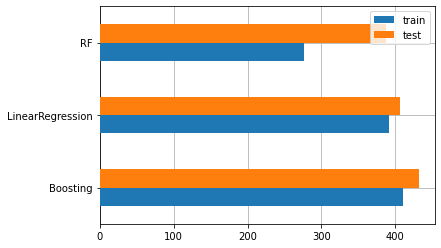

In [89]:
# Plot evaluasi
fig, ax = plt.subplots()
mae.sort_values(by='test', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)

Random Forest memiliki performa terbaik dalam melakukan prediksi harga kost baik untuk data latih dan data test. Kemudian diikuti oleh Linear Regression dan yang terakhir adalah Ada Boosting.

Adapun `MAE` terbaik untuk data latih memiliki nilai `277` dimana dapat diinterpretasikan bahwa rata-rata rentang kesalahan sebesar `277` dari nilai yang sebenarnya. Ini berarti jika sebuah kost seharusnya berharga `1500 (atau 1,5 juta)`, maka mungkin model memprediksi diantara rentang `1223 (1,223 juta)` hingga `1777 (1,77 juta)`. Begitupun untuk data test dimana `MAE` bernilai `387` dapat diinterpretasikan dengan cara yang sama.

Perbandingan antara evaluasi `Random Forest` dengan `Linear Regression` adalah perbedaan rentang `MAE` untuk data training dengan data test. `Random Forest` memiliki jarak hingga `110 (110 rb)` antara training dan test. Sedangkan `Linear Regression` memiliki rentang/jarak yang kecil antara `MAE` training dan test yaitu hanya `15 (15 ribu)`.

Dalam hal ini bisa saja `Random Forest` mengalami **overgfit** dimana model terlalu baik dalam memprediksi data latih namun performanya buruk terhadap data yang belum pernah dilihatnya. Ini berbeda dengan `Linear Regression` yang tidak mengalami **overfit** karena performa terhadap data latih dan data test tidak begitu jauh.

In [100]:
prediksi = X_test.iloc[[0]].copy()
pred = {'y_aktual':y_test.iloc[0]}

for name, model in model_dict.items():
    pred['Prediksi_' + name] = model.predict(prediksi).round(1)

pd.DataFrame(pred)

,y_aktual,Prediksi_LinearRegression,Prediksi_RF,Prediksi_Boosting
0,1500.0,1337.5,1457.3,1800.8


In [101]:
prediksi

,aircon,free_wifi,kamar_mandi_dalam,TV_fkamar,Pemanas Air (Water Heater)_fkamar,Keamanan_fkost,Ruang Tamu_fkost,Ruang Makan_fkost,Air Minum_fkost,Pembantu_fkost,Parkir Mobil_fkost,jenis_Kost Campur,jenis_Kost Pasutri,jenis_Kost Putra,jenis_Kost Putri
40,1,0,1,0,0,1,1,0,0,0,0,0,0,0,1


Salah satu sampel yang diambil adalah kost putri dengan fasilitas kamar AC dan kamar mandi dalam serta fasilitas kost keamanan dan ruang tamu dengan harga 1,5 juta. Model Linear Regression memprediksi dengan harga lebih rendah namun hanya dengan rentang 160an rb, model Boosting memprediksi dengan harga lebih mahal 300 rb, dan Random Forest memprediksi dengan harga yang paling mendekati untuk data aktual.

In [196]:
407 / (y.max() - y.min())

0.11305555555555556

**ARGUMEN:**

Walaupun MAE terbaik berada pada rentang 7 - 12% dari rentang total data (y max - y min = 3600). Namun model ini dibuat untuk generalisasi dalam prediksi harga kost agar harga kost dapat bersaing dengan kost dengan fasilitas setara serta mendapatkan keuntungan yang maksimal (kost mendekati harga wajar). Sehingga performa dari model dianggap sudah baik dalam menentukan harga kost yang dapat bersaing dengan harga yang wajar. (Didasari pendapat subjektif penulis)

# Interpretasi Model

## Linear Regression

Dari ketiga model yang dibuat ingin diketahui bagaimana cara model dalam menentukan harga dengan masukan informasi fasilitas. Untuk model `LinearRegression` sendiri adalah model deterministik, dimana object dari `LinearRegression` yang telah dilakukan fitting model menyimpan persamaan linear. Sehingga model ini akan terus menghasilkan output yang sama untuk masukan dengan kondisi yang sama.<sup>[[6](http://www.scholarpedia.org/article/Dynamical_systems)]</sup>

Kode di bawah untuk melihat persamaan dari model yang terbentuk dari hasil pelatihan dengan data training.

In [91]:
# Melihat intersep persamaan
model_lr.intercept_

998.0103988828553

In [92]:
# Masing-masing koefisien dari persamaan
model_lr.coef_

array([ 618.92216099,  199.79272872,  206.17075191,  179.18222558,
        518.70714468,  -83.40437909, -111.26936511,  145.13969436,
         69.08734462,  -62.03623055,  132.45729682, -111.02204263,
        739.13794229, -337.22605864, -290.88984102])

In [93]:
# x persamaan
model_lr.feature_names_in_

array(['aircon', 'free_wifi', 'kamar_mandi_dalam', 'TV_fkamar',
       'Pemanas Air (Water Heater)_fkamar', 'Keamanan_fkost',
       'Ruang Tamu_fkost', 'Ruang Makan_fkost', 'Air Minum_fkost',
       'Pembantu_fkost', 'Parkir Mobil_fkost', 'jenis_Kost Campur',
       'jenis_Kost Pasutri', 'jenis_Kost Putra', 'jenis_Kost Putri'],
      dtype=object)

Untuk membuktikan deterministik dan konsistensi prediksi `model_lr` yang telah kita buat, akan kita gunakan data test dengan index 0 dengan menhitung secara manual, yaitu menghitung dengan cara `prediksi = koef * variabel + intersep`.

In [126]:
# Membuat dataframe untuk variabel, koefisien serta contoh data yang akan diprediksi
lr_interpret = pd.DataFrame(
    {'variabel': model_lr.feature_names_in_, # nama variabel
    'koef':model_lr.coef_, # Besaran koefisien variable
    'data': X_test.iloc[0].to_list() # Informasi fasilitas data test index 0
    })

# Menghitung hasil perkalian antara data dengan koef
lr_interpret['data*koef'] = lr_interpret['koef'] * lr_interpret['data']

lr_interpret

,variabel,koef,data,data*koef
0,aircon,618.922161,1,618.922161
1,free_wifi,199.792729,0,0.000000
2,kamar_mandi_dalam,206.170752,1,206.170752
3,TV_fkamar,179.182226,0,0.000000
4,Pemanas Air (Water Heater)_fkamar,518.707145,0,0.000000
5,Keamanan_fkost,-83.404379,1,-83.404379
6,Ruang Tamu_fkost,-111.269365,1,-111.269365
7,Ruang Makan_fkost,145.139694,0,0.000000
8,Air Minum_fkost,69.087345,0,0.000000
9,Pembantu_fkost,-62.036231,0,-0.000000


Variabel `aircon` memiliki koefisien terbesar, yang dimana dapat diinterpretasian bahwa variabel tersebut sangat berpengaruh terhadap kenaikan harga, dimana ketika suatu kost mempunyai fasilitas `aircon` maka akan menaikkan harga sebesar **618 rb**, diikuti dengan variabel `water heather` dan juga `kamar_mandi_dalam`. Ini selaras dengan hasil korelasi pada eksplorasi data dimana korelasi tertinggi terhadpa harga adalah ketiga variabel tersebut.

Kita telah mendapatkan hasil perhitungan masing-masing masukan variabel untuk contoh data test yang telah dikalikan dengan koefisiennya. Selanjutnya untuk menentukan output terakhir yaitu menjumlahkan seluruh perkalian antar variabel kemudian menambahkan dengan intersep.

In [124]:
# Menghitung output total dengan menambahkan intersep
lr_interpret['prediksi*koef'].sum() + model_lr.intercept_

1337.539726551887

In [122]:
# Hasil prediksi model untuk data test index 0
model_lr.predict(X_test.iloc[[0]])

array([1337.53972655])

Dari hasil komputasi secara manual dan juga hasil prediksi dari objek `model_lr` memiliki hasil yang sama untuk contoh masukan yang sama.

## Random Forest

Random Forest bukanlah model deterministik karena penentuan outputnya menggunakan probabilitas/*randomness*, model seperti ini disebut sebagai *stochastic model*.<sup>[ [7](https://blog.ev.uk/stochastic-vs-deterministic-models-understand-the-pros-and-cons) ]</sup>

Karena Adaboost juga termasuk ke dalam *stochastic model*, maka dari itu kita hanya akan melakukan interpretasi untuk model *stochastic* terbaik, yaitu **Random Forest**

Karena sifatnya yang tidak tetap untuk setiap outputnya, sehingga digunakan *Mean Decreased Impurity (MDI)* untuk mengetahui variabel/prediktor apa saja yang paling mempengaruhi prediksi model. MDI menghitung rata-rata dan standar deviasi dari akumulasi penurunan kualitas dari setiap pohonnya (jika nilai prediktor diubah, dibuat menjadi *impure*) Nilai MDI dari setiap prediktor tersimpan dalam atribut `feature_importance_`.<sup>[[8](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)]</sup>



Dengan nilai MDI ini kita akan melihat prediktor mana memiliki MDI terbesar, atau dengan kata lain prediktor yang paling mempengaruhi model dalam penentuan harga.

In [138]:
import time

start_time = time.time()
# Mendapatkan nilai MDI setiap prediktor
importances = RF.feature_importances_
# Mendapatkan nilai prediktor
feature_names = RF.feature_names_in_
# Menghitung std MDI setiap prediktor
std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.077 seconds


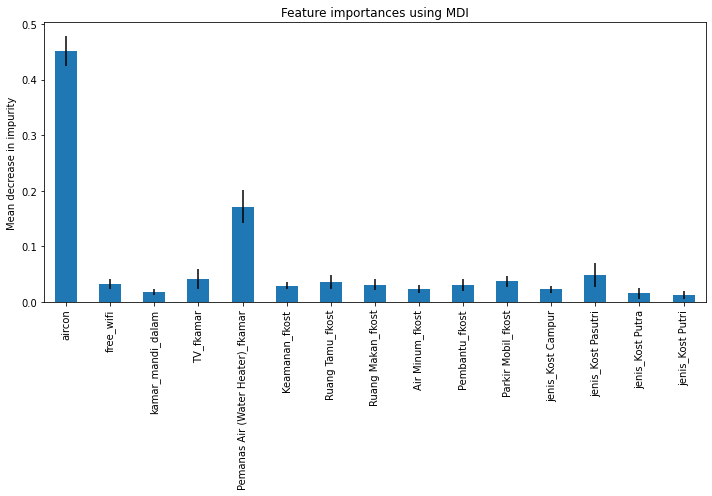

In [139]:
# Visualisasi MDI untuk setiap prediktor
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(10,7))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Dari plot MDI di atas dapat terlihat bahwa `aircon` adalah prediktor yang paling mempengaruhi prediksi model, diikuti oleh `Water Heater`.

# Kesimpulan & Saran

## Kesimpulan

Berdasarkan hasil notebook ini, didapat beberapa kesimpulan:
1. Model terbaik untuk memprediksi harga kost adalah Random Forest Regressor dengan nilai MAE pada training sebesar 277 dan testing 387 (dalam satuan ribu). Model kedua terbaik adalah Linear Regression dengan nilai MAE pada data training 392 dan pada testing sebesar 407 (dalam satuan ribu)
2. Perbedaan performa antara data training dan testing untuk Random Forest Regressor cenderung jauh, ini memungkinan bahwa Random Forest Regressor mengalami overfit. Berbeda dengan Linear Regression yang perbedaan performa antara training dan testing yang kecil.
3. Variabel yang paling berpengaruh adalah AC (aircon) dalam prediksi harga baik untuk model Linear Regression dan Random Forest. Sehingga AC adalah fasilitas yang dapat menaikkan harga kost secara signifikan.

## Saran

Berdasarkan hasil notebook ini, data yang digunakan masih terbilang sederhana karena kesemua kolom dalam bentuk boolean/biner. Masih terdapat kemungkinan informasi penting yang tidak menjadi masukan dari model seperti luas kamar serta kecamatan dari kost tersebut. Kemudian penggunaan model juga masih terbilang sederhana dan belum dilakukan tuning terhadap model-model terbaik. 

Oleh karena itu penulis menyarankan untuk menggunakan dataset yang lebih lengkap dan juga melakukan peningkatan performa model dengan cara melakukan tuning ataupun menggunakan model yang lebih *advance*.

# Referensi

[1] [Binary Encoding](https://www.sciencedirect.com/topics/engineering/binary-encoding)

[2] [One Hot Encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)

[3] [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

[4] [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

[5] [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html)

[6] [Deterministic System](http://www.scholarpedia.org/article/Dynamical_systems)

[7] [Stochastic System](https://blog.ev.uk/stochastic-vs-deterministic-models-understand-the-pros-and-cons)

[8] [Feature Importance](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)